<a href="https://colab.research.google.com/github/prijall/DeepLearning/blob/main/AutoEncoder_Vanilla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
!pip install -q torch_snippets
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

In [36]:
import torch
device='cuda' if torch.cuda.is_available() else 'cpu'

In [37]:
img_transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

In [38]:
train_ds=MNIST('/content/', train=True, transform=img_transform, download=True)
val_ds=MNIST('/content/', train=False, transform=img_transform, download=True)

In [39]:
batch_size=256
train_dl=DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl=DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [40]:
import torch.nn as nn
class AutoEncoder(nn.Module):
  def __init__(self, bottleneck_dim):
    super().__init__()
    self.encoder=nn.Sequential(
        nn.Linear(28*28, 128),
        nn.ReLU(True),
        nn.Linear(128, 64),
        nn.ReLU(True),
        nn.Linear(64, bottleneck_dim)
    )

    self.decoder=nn.Sequential(
        nn.Linear(bottleneck_dim, 64),
        nn.ReLU(True),
        nn.Linear(64, 128),
        nn.ReLU(True),
        nn.Linear(128, 28*28),
        nn.Tanh()
    )

  def forward(self, x):
    x=x.view(len(x), -1)
    x=self.encoder(x)
    x=self.decoder(x)
    x=x.view(len(x), 1, 28, 28)
    return x

In [41]:
def train_batch(input, model, criterion, optimizer):
  model.train()
  optimizer.zero_grad()
  output=model(input)
  loss=criterion(output, input)
  loss.backward()
  optimizer.step()
  return loss


In [42]:
@torch.no_grad()
def validate_batch(input, model, criterion):
  model.eval()
  output=model(input)
  loss=criterion(output, input)
  return loss

In [43]:
model=AutoEncoder(3).to(device)
criterion=nn.MSELoss()
optimizer=torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

In [44]:
num_epochs = 10

train_losses = []
val_losses = []

for epoch in range(num_epochs):
  epoch_train_losses = []
  epoch_val_losses = []

  # Training loop
  N = len(train_dl)
  for ix, (data, _) in enumerate(train_dl):
    loss = train_batch(data, model, criterion, optimizer)
    epoch_train_losses.append(loss.item())  # Store loss as a number
    print(f"Epoch {epoch+1}/{num_epochs}, Batch {ix+1}/{N}, Training Loss: {loss.item():.4f}", end='\r')

  # Validation loop
  N = len(val_dl)
  for ix, (data, _) in enumerate(val_dl):
    loss = validate_batch(data, model, criterion)
    epoch_val_losses.append(loss.item())  # Store loss as a number
    print(f"Epoch {epoch+1}/{num_epochs}, Batch {ix+1}/{N}, Validation Loss: {loss.item():.4f}", end='\r')

  # Calculate and print average losses for the epoch
  avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
  avg_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)

  train_losses.append(avg_train_loss)  # Store average losses for plotting later if needed
  val_losses.append(avg_val_loss)

  print(f"Epoch {epoch+1}/{num_epochs} - Avg. Training Loss: {avg_train_loss:.4f}, Avg. Validation Loss: {avg_val_loss:.4f}")

Epoch 1/10 - Avg. Training Loss: 0.2591, Avg. Validation Loss: 0.1934
Epoch 2/10 - Avg. Training Loss: 0.1807, Avg. Validation Loss: 0.1695
Epoch 3/10 - Avg. Training Loss: 0.1646, Avg. Validation Loss: 0.1601
Epoch 4/10 - Avg. Training Loss: 0.1567, Avg. Validation Loss: 0.1536
Epoch 5/10 - Avg. Training Loss: 0.1521, Avg. Validation Loss: 0.1502
Epoch 6/10 - Avg. Training Loss: 0.1490, Avg. Validation Loss: 0.1477
Epoch 7/10 - Avg. Training Loss: 0.1466, Avg. Validation Loss: 0.1455
Epoch 8/10 - Avg. Training Loss: 0.1447, Avg. Validation Loss: 0.1438
Epoch 9/10 - Avg. Training Loss: 0.1431, Avg. Validation Loss: 0.1422
Epoch 10/10 - Avg. Training Loss: 0.1415, Avg. Validation Loss: 0.1408


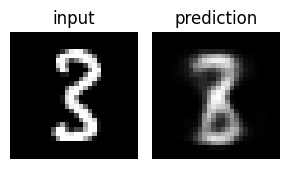

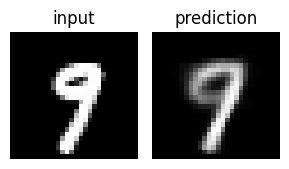

In [48]:
import matplotlib.pyplot as plt
for _ in range(2):
 ix = np.random.randint(len(val_ds))
 im, _ = val_ds[ix]
 _im = model(im[None])[0]
 fig, ax = plt.subplots(1, 2, figsize=(3,3))
 show(im[0], ax=ax[0], title='input')
 show(_im[0], ax=ax[1], title='prediction')
 plt.tight_layout()
 plt.show()